# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.


**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

     |████████████████████████████████| 5.4MB 3.4MB/s 
     |████████████████████████████████| 102kB 23.6MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [0]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.  
[https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database)  
Loads about 55 MB

In [3]:
mnist = fetch_openml('mnist_784', cache=False)
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively. Values are scaled to the range of [0, 1]. Data are not normalized.

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X.min(), X.max()

(0.0, 1.0)

Split train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

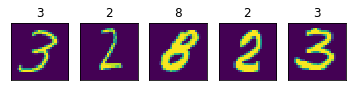

In [9]:
def plot_example(X, y):
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [0]:
import torch
from torch import nn
import torch.nn.functional as F

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [0]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [0]:
from skorch import NeuralNetClassifier

In [17]:
torch.manual_seed(10)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    #max_epochs=50,
    lr=0.1,
    device=device,
)

net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8241       0.8832        0.4101  1.1068
      2        0.4241       0.9161        0.2984  0.9746
      3        0.3528       0.9277        0.2534  1.0034
      4        0.3136       0.9334        0.2272  1.0195
      5        0.2825       0.9395        0.2058  1.0612
      6        0.2639       0.9429        0.1924  0.9509
      7        0.2494       0.9453        0.1836  1.0211
      8        0.2355       0.9513        0.1659  1.0031
      9        0.2252       0.9505        0.1620  1.0004
     10        0.2160       0.9531        0.1550  0.9876
     11        0.2063       0.9571        0.1475  0.9767
     12        0.2029       0.9586        0.1409  0.9916
     13        0.1974       0.9583        0.1391  0.9607
     14        0.1916       0.9583        0.1387  0.9855
     15        0.1869       0.9601        0.1334  0.9694
     16        0.1817       0.9

## Prediction

In [0]:
from sklearn.metrics import accuracy_score

In [18]:
y_pred = net.predict(X_test)
accuracy_score(y_test, y_pred)

0.9702285714285714


Let's take a look at some predictions that went wrong:

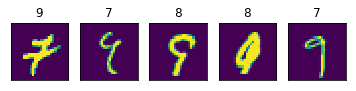

In [19]:
error_mask = y_pred != y_test
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [31]:
XCnn = X.reshape(-1, 1, 28, 28)
XCnn.shape

(70000, 1, 28, 28)

In [32]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [0]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [40]:
torch.manual_seed(20)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=6,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4452       0.9659        0.1086  2.7723
      2        0.1826       0.9781        0.0721  2.8061
      3        0.1466       0.9832        0.0557  2.7738
      4        0.1203       0.9845        0.0500  2.7628
      5        0.1103       0.9851        0.0469  2.7886
      6        0.1002       0.9859        0.0445  2.7636


In [41]:
y_pred_cnn = cnn.predict(XCnn_test)
accuracy_score(y_test, y_pred_cnn)

0.9855428571428572


Let's see how we fare on the examples that went wrong before:

In [42]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.6391554702495201

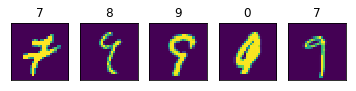

In [43]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])